In [1]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units
import datetime

plt.rcParams.update({
    "figure.facecolor": (1,1,1,1),
    "axes.facecolor": (1,1,1,1),
    "savefig.facecolor": (1,1,1,1),
})

In [2]:
# get data
df = pd.read_csv(os.path.join("..", "FlightData", "Spring2025", "RAWDATA9.csv"))

graph_folder = "Spring2025Graphs"

In [3]:
# data
wind_speed = []
course = []
pres = []
temp = []
rel_hum = [] 

last_pres = 10000
for index, row in df.iterrows():
    if last_pres < 100: break
    if pd.isnull(df.loc[index, "MTK3339 Speed"]) == False and pd.isnull(df.loc[index, "BMP390 Pressure (Pa)"]) == False and row["BMP390 Pressure (Pa)"] / 100 < last_pres:
        wind_speed.append(row["MTK3339 Speed"] * 0.001 * 0.2777778)
        course.append(row["MTK3339 Heading"] * 10**-5)
        pres.append(row["BMP390 Pressure (Pa)"] / 100)
        last_pres = row["BMP390 Pressure (Pa)"] / 100

        temp.append(row["TMP117_O Temp_O (C)"])
        rel_hum.append(row["SHTC3_O Rel_Hum_O (%)"] / 100)
#         data_index += 1
        
#     print(target_time, index_time, data_index, wind_speed[-1], course[-1], pres[-1], temp[-1], rel_hum[-1])
    
    #if(flash_df["BMEPress(hPa)"][data_index] < 100): break

step = 5
wind_speed = [wind_speed[i] for i in range(0, len(wind_speed), step)]
course = [360-course[i] for i in range(0, len(course), step)]
pres = [pres[i] for i in range(0, len(pres), step)]
temp = [temp[i] for i in range(0, len(temp), step)]
rel_hum = [rel_hum[i] for i in range(0, len(rel_hum), step)]


print(len(wind_speed), len(course), len(pres), len(temp), len(rel_hum), sep="\t")
print("Speed", "Course", "Pres", "Temp", "Rel Hum", sep="\t")
for i in range(10):   #(len(wind_speed)):
    print(round(wind_speed[i], 4), round(course[i],2), round(pres[i],2), round(temp[i],2), round(rel_hum[i], 4), sep="\t")


134	134	134	134	134
Speed	Course	Pres	Temp	Rel Hum
0.0	360.0	946.32	26.78	0.1965
0.0108	360.0	946.29	26.02	0.2006
0.0144	277.41	946.26	24.3	0.2199
0.9831	223.21	940.5	21.05	0.2481
2.1753	291.74	928.43	20.02	0.2571
1.0844	250.45	915.12	18.71	0.2691
1.1025	281.79	903.13	17.91	0.2808
2.3525	309.19	889.89	16.49	0.2936
1.1725	281.88	877.23	16.12	0.3024
2.3414	335.0	865.41	14.95	0.3064


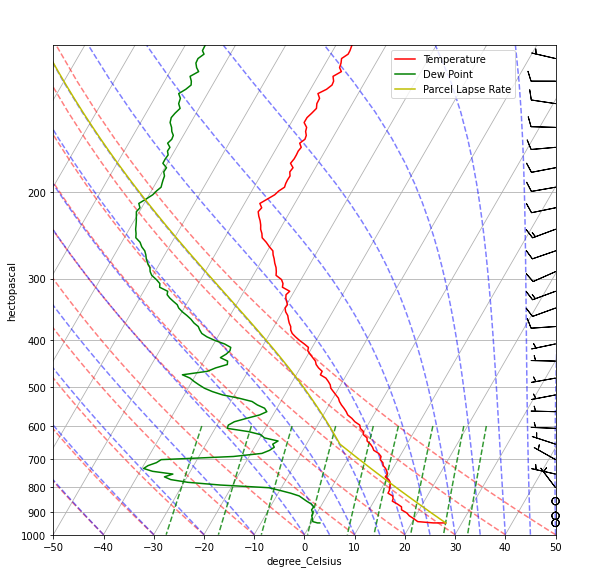

In [4]:
# skewT
fig = plt.figure(figsize = (9,9))
skew = SkewT(fig=fig, aspect='auto')

pres = np.array(pres) * units.hPa
temp = np.array(temp) * units.degC
rel_hum = np.array(rel_hum) * units.dimensionless
dewpoint = mpcalc.dewpoint_from_relative_humidity(temperature=temp, relative_humidity=rel_hum)

prof = mpcalc.parcel_profile(pres, temp[0], dewpoint[0]).to('degC')

# # fix with aprs data 
# u = wind_speed * units.knots
# v = np.linspace(-20, 20, len(pres)) * units.knots

wind_speed = np.array(wind_speed) * units("m/s")
course = np.array(course) * units.deg

u, v = mpcalc.wind_components(wind_speed, course)
# u = np.linspace(-10, 10, len(pres)) * units.knots
# v = np.linspace(-20, 20, len(pres)) * units.knots

skew.plot(pres, temp, 'r')
skew.plot(pres, dewpoint, 'g')
skew.plot(pres, prof, 'y')
skew.plot_barbs(pres[::5], u[::5], v[::5])

skew.ax.set_xlim(-50, 50)
skew.ax.set_ylim(1000, min(pres))

skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

plt.legend(("Temperature","Dew Point", "Parcel Lapse Rate"), shadow=False, fancybox=True, bbox_to_anchor = [0.93, 1]) #Legend providing same color for both


plt.savefig(os.path.join(graph_folder, f"skewTLogP.svg"))
plt.savefig(os.path.join(graph_folder, f"skewTLogP.png"))

plt.show()